<a href="https://colab.research.google.com/github/Nageswar-Sahoo/S5/blob/main/EVA7_Assignment_S5_File_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [ ]:

dropout=.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout),
            nn.ReLU()
        ) # output_size = 26


        # Input Block
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout),
            nn.ReLU()
        ) # output_size = 24
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout),
            nn.ReLU()
        ) # output_size = 9

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout),
            nn.ReLU()
        ) # output_size = 7
         # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout),
            nn.ReLU()
        ) # output_size = 5

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout),
            nn.ReLU()
        ) # output_size = 5
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # out

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             576
      BatchNorm2d-10            [-1, 8, 22, 22]              16
          Dropout-11            [-1, 8, 22, 22]               0
             ReLU-12            [-1, 8, 22, 22]               0
        MaxPool2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:

##dropout=.01  with scheduler scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.07128511369228363 Batch_id=468 Accuracy=92.70: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]



Test set: Average loss: 0.0492, Accuracy: 9858/10000 (98.58%)

EPOCH: 1


Loss=0.08621435612440109 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]



Test set: Average loss: 0.0399, Accuracy: 9876/10000 (98.76%)

EPOCH: 2


Loss=0.06246548518538475 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]



Test set: Average loss: 0.0672, Accuracy: 9792/10000 (97.92%)

EPOCH: 3


Loss=0.07896336168050766 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]



Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

EPOCH: 4


Loss=0.017942262813448906 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]



Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 5


Loss=0.026288500055670738 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]



Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 6


Loss=0.005410235375165939 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:22<00:00, 20.59it/s]



Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.018668945878744125 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]



Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.0169126745313406 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]



Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.019229037687182426 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]



Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.048454463481903076 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]



Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.021517759189009666 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]



Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.032408274710178375 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]



Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.008277316577732563 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]



Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.016801172867417336 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]



Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)



In [ ]:

##dropout=.01  with scheduler = StepLR(optimizer, step_size=2, gamma=0.5)


from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.8)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.024796558544039726 Batch_id=468 Accuracy=93.64: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]



Test set: Average loss: 0.0502, Accuracy: 9837/10000 (98.37%)

EPOCH: 1


Loss=0.0023231131490319967 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]



Test set: Average loss: 0.0345, Accuracy: 9893/10000 (98.93%)

EPOCH: 2


Loss=0.05934940651059151 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]



Test set: Average loss: 0.0308, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.008639708161354065 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]



Test set: Average loss: 0.0298, Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.01270674541592598 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]



Test set: Average loss: 0.0272, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.07105399668216705 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 21.31it/s]



Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.01095438003540039 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]



Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.007052891422063112 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:23<00:00, 20.08it/s]



Test set: Average loss: 0.0252, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.01666807383298874 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]



Test set: Average loss: 0.0178, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.004952401388436556 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]



Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.005433660000562668 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]



Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.019736487418413162 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0181, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.003896266920492053 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]



Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.04213733598589897 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:23<00:00, 19.96it/s]



Test set: Average loss: 0.0181, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.049477871507406235 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:23<00:00, 19.79it/s]



Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)



In [ ]:

##dropout=.01  with scheduler = StepLR(optimizer, step_size=2, gamma=0.4)


from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.4)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.030483433976769447 Batch_id=468 Accuracy=93.42: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]



Test set: Average loss: 0.0561, Accuracy: 9824/10000 (98.24%)

EPOCH: 1


Loss=0.06677425652742386 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]



Test set: Average loss: 0.0489, Accuracy: 9834/10000 (98.34%)

EPOCH: 2


Loss=0.018780721351504326 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]



Test set: Average loss: 0.0306, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


Loss=0.0017704414203763008 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]



Test set: Average loss: 0.0310, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.002255199709907174 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 5


Loss=0.03886203095316887 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]



Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.0054790000431239605 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]



Test set: Average loss: 0.0227, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.007209939882159233 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]



Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.023395098745822906 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.001713709905743599 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]



Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.012736515142023563 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]



Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.016194280236959457 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]



Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.0037452494725584984 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]



Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.007111934944987297 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]



Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.14313443005084991 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]



Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)



In [ ]:

##dropout=.01  with scheduler = StepLR(optimizer, step_size=2, gamma=0.5)


from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.07364773005247116 Batch_id=468 Accuracy=92.09: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]



Test set: Average loss: 0.0674, Accuracy: 9776/10000 (97.76%)

EPOCH: 1


Loss=0.05496877804398537 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]



Test set: Average loss: 0.0427, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.05753420293331146 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:22<00:00, 21.32it/s]



Test set: Average loss: 0.0303, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Loss=0.11380353569984436 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]



Test set: Average loss: 0.0322, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.12443865090608597 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 21.32it/s]



Test set: Average loss: 0.0244, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


Loss=0.006227120757102966 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]



Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

EPOCH: 6


Loss=0.019030578434467316 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]



Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.012305893003940582 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]



Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.006463984027504921 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.017056932672858238 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]



Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.005011535715311766 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]



Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.058559317141771317 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 21.32it/s]



Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.048349615186452866 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]



Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.008508528582751751 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]



Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.015661323443055153 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]



Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)



In [ ]:

##dropout=.01  with scheduler = StepLR(optimizer, step_size=3, gamma=0.6)


from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.6)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.07584894448518753 Batch_id=468 Accuracy=93.28: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]



Test set: Average loss: 0.0614, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.05673813819885254 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]



Test set: Average loss: 0.0361, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.07445203512907028 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]



Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

EPOCH: 3


Loss=0.0026412748266011477 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0294, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.00681330868974328 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]



Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)

EPOCH: 5


Loss=0.020798491314053535 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]



Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.005443560425192118 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]



Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)

EPOCH: 7


Loss=0.006054149940609932 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]



Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 8


Loss=0.022747160866856575 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]



Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

EPOCH: 9


Loss=0.010960395447909832 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]



Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)

EPOCH: 10


Loss=0.04422583803534508 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]



Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.0024763590190559626 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]



Test set: Average loss: 0.0157, Accuracy: 9951/10000 (99.51%)

EPOCH: 12


Loss=0.0008387898560613394 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)

EPOCH: 13


Loss=0.0013749400386586785 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]



Test set: Average loss: 0.0164, Accuracy: 9951/10000 (99.51%)

EPOCH: 14


Loss=0.009129290468990803 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0159, Accuracy: 9951/10000 (99.51%)



In [ ]:

##dropout=.01  with scheduler = StepLR(optimizer, step_size=2, gamma=0.7)


from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.05779111385345459 Batch_id=468 Accuracy=93.57: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]



Test set: Average loss: 0.0582, Accuracy: 9834/10000 (98.34%)

EPOCH: 1


Loss=0.018224390223622322 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]



Test set: Average loss: 0.0417, Accuracy: 9879/10000 (98.79%)

EPOCH: 2


Loss=0.09523492306470871 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]



Test set: Average loss: 0.0345, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.044242460280656815 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]



Test set: Average loss: 0.0332, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.008605984039604664 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]



Test set: Average loss: 0.0273, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.012316384352743626 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]



Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.009834668599069118 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0222, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.02480618841946125 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]



Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.015241400338709354 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:22<00:00, 20.59it/s]



Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.004720669239759445 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.0057250880636274815 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]



Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.06697098165750504 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]



Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.023620257154107094 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]



Test set: Average loss: 0.0199, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.02212635427713394 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.011332192458212376 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]



Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)



In [ ]:

##dropout=.01  with scheduler = StepLR(optimizer, step_size=2, gamma=0.8)


from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.8)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.04389464482665062 Batch_id=468 Accuracy=93.96: 100%|██████████| 469/469 [00:23<00:00, 20.28it/s]



Test set: Average loss: 0.0802, Accuracy: 9769/10000 (97.69%)

EPOCH: 1


Loss=0.09156384319067001 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]



Test set: Average loss: 0.0469, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.04322925582528114 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]



Test set: Average loss: 0.0319, Accuracy: 9892/10000 (98.92%)

EPOCH: 3


Loss=0.02333546243607998 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s]



Test set: Average loss: 0.0308, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.054092392325401306 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]



Test set: Average loss: 0.0268, Accuracy: 9924/10000 (99.24%)

EPOCH: 5


Loss=0.06373954564332962 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]



Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.008156592957675457 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:23<00:00, 20.39it/s]



Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.0030743367969989777 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:23<00:00, 20.38it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.04115710034966469 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]



Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

EPOCH: 9


Loss=0.023003345355391502 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]



Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


Loss=0.027802348136901855 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.004602891858667135 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


Loss=0.020367704331874847 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]



Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

EPOCH: 13


Loss=0.05761738494038582 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]



Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.0662761777639389 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]



Test set: Average loss: 0.0163, Accuracy: 9949/10000 (99.49%)



In [ ]:

##dropout=.01  with scheduler = StepLR(optimizer, step_size=2, gamma=0.9)


from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.9)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.07757112383842468 Batch_id=468 Accuracy=93.39: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]



Test set: Average loss: 0.0464, Accuracy: 9868/10000 (98.68%)

EPOCH: 1


Loss=0.006615293677896261 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]



Test set: Average loss: 0.0382, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Loss=0.092031329870224 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]



Test set: Average loss: 0.0343, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.03916170820593834 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]



Test set: Average loss: 0.0263, Accuracy: 9926/10000 (99.26%)

EPOCH: 4


Loss=0.033393215388059616 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]



Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

EPOCH: 5


Loss=0.026816068217158318 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0273, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.014621148817241192 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]



Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 7


Loss=0.01358215045183897 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]



Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.0372675396502018 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.025418534874916077 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.02782263420522213 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]



Test set: Average loss: 0.0207, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.008774930611252785 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]



Test set: Average loss: 0.0205, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.035360146313905716 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]



Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.02479674480855465 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]



Test set: Average loss: 0.0199, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.0007793806144036353 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]



Test set: Average loss: 0.0186, Accuracy: 9949/10000 (99.49%)



In [ ]:

##dropout=.01  with scheduler = StepLR(optimizer, step_size=2, gamma=0.9)


from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.6)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.09464593976736069 Batch_id=468 Accuracy=86.60: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]



Test set: Average loss: 0.0891, Accuracy: 9762/10000 (97.62%)

EPOCH: 1


Loss=0.1653551608324051 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]



Test set: Average loss: 0.0586, Accuracy: 9830/10000 (98.30%)

EPOCH: 2


Loss=0.043933022767305374 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0394, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.022346707060933113 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]



Test set: Average loss: 0.0333, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.08223282545804977 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]



Test set: Average loss: 0.0294, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.009748702868819237 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]



Test set: Average loss: 0.0271, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.0634588822722435 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]



Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.03214164450764656 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]



Test set: Average loss: 0.0248, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.033123377710580826 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]



Test set: Average loss: 0.0237, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.018382839858531952 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]



Test set: Average loss: 0.0241, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.05223852023482323 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]



Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.021304232999682426 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]



Test set: Average loss: 0.0227, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.007348908111453056 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]



Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.01057054940611124 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]



Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.013832978904247284 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]



Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)



In [ ]:

##dropout=.01  with scheduler = StepLR(optimizer, step_size=2, gamma=0.5)


from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.1291932612657547 Batch_id=468 Accuracy=93.42: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]



Test set: Average loss: 0.0724, Accuracy: 9776/10000 (97.76%)

EPOCH: 1


Loss=0.027626439929008484 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]



Test set: Average loss: 0.0358, Accuracy: 9890/10000 (98.90%)

EPOCH: 2


Loss=0.031395938247442245 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]



Test set: Average loss: 0.0234, Accuracy: 9934/10000 (99.34%)

EPOCH: 3


Loss=0.025160595774650574 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]



Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)

EPOCH: 4


Loss=0.025911057367920876 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]



Test set: Average loss: 0.0224, Accuracy: 9934/10000 (99.34%)

EPOCH: 5


Loss=0.04353564605116844 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]



Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 6


Loss=0.029160000383853912 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]



Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

EPOCH: 7


Loss=0.009454386308789253 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH: 8


Loss=0.011968611739575863 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]



Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


Loss=0.002638014033436775 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]



Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 10


Loss=0.022445999085903168 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]



Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 11


Loss=0.001688079908490181 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]



Test set: Average loss: 0.0181, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


Loss=0.0064031207002699375 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]



Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.009431667625904083 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]



Test set: Average loss: 0.0180, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.009719169698655605 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]



Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)



Text(0.5, 1.0, 'Test Accuracy')

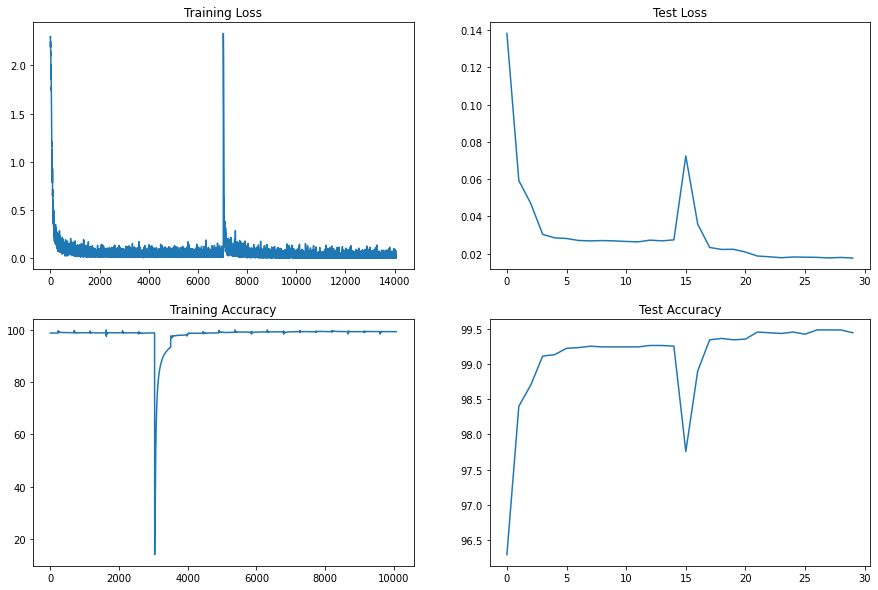

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

1 - Target: Try LR Scheduler to Achive High Accuracy

2 - Results:

    1 - Parameters: 10k
    1 - Best Train Accuracy: 99.44 (At EPOCH - 12 , StepLR step_size=2, gamma=0.6)
    1 - Best Test Accuracy: 99.53  (At EPOCH - 12 , StepLR step_size=2, gamma=0.6)
3 - Analysis:

    Finding a good LR schedule is hard.
    Initially we tried with learning rate 0. 01 . Above Learning rate with
    Scheduler help us to achieve the highest train accuracy of 99.10 and test 
    accuracy of 99.39. As training accuracy is less if we can somehow increase
    this accuracy then overall model accuracy on test data can also be
    increased .Hence we have started exploring with learning rate 0. 1 . We 
    have tried to make it effective by  reducing LR by 0.6 after the 2th  
    epoch.  Above Learning rate with Scheduler help us to achieve the highest
    test  accuracy of 99.53.
